In [ ]:
!pip3 install seaborn
!pip install lxml
!pip install pandas_read_xml

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import pandas_read_xml as pdx

from scipy.spatial.distance import cosine

from sklearn.metrics import precision_recall_curve

In [45]:
pd.set_option('max_colwidth', 150)

In [3]:
USE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
SEED = 2022

model = hub.load(USE_URL)

In [4]:
def get_embeddings(text):
  return model(text)

### Utils

In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Embeddings similarity")

In [ ]:
def plot_pr_curve(duplicate_score, similarity):
    precision, recall, thresholds = precision_recall_curve(duplicate_score, similarity)
    df = pd.DataFrame({'recall': recall[:-1], 'precision': precision[:-1], 'threshold': thresholds})
    fig = px.area(
        df,
        x='recall', y='precision', 
        labels=dict(x='Recall', y='Precision'),
        hover_data=["recall", "precision", 'threshold'],
        width=1000, height=600
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')

    fig.show()

### Get data

In [ ]:
data = pd.read_csv('data_generation_1.csv')
data.head()

Unnamed: 0      id    qid1    qid2  \
0      363696  363696  493696  493697   
1      127668  127668  205495  142438   
2      370413  370413    1596   50007   
3      304378  304378   10280   11510   
4      261965  261965  145906  162176   

                                           question1  \
0              What causes hallucinations from weed?   
1                                 Why is CNN biased?   
2  What are the safety precautions on handling sh...   
3           Why do long distance relationships fail?   
4  What signs a girl gives when she is interested...   

                                           question2  is_duplicate  
0        How is Zong weed different from other weed?             0  
1              In what ways is CNN biased, if it is?             1  
2  What are the safety precautions on handling sh...             1  
3  How can I maintain my long distance relationsh...             1  
4  What are the signals that a girl gives if she'...             1

In [ ]:
top_5_questions = data.iloc[:5]['question1'].values.tolist()
top_5_questions.extend(data.iloc[:5]['question2'].values.tolist())
top_5_questions

['What causes hallucinations from weed?',
 'Why is CNN biased?',
 'What are the safety precautions on handling shotguns proposed by the NRA in Arizona?',
 'Why do long distance relationships fail?',
 'What signs a girl gives when she is interested in a guy?',
 'How is Zong weed different from other weed?',
 'In what ways is CNN biased, if it is?',
 'What are the safety precautions on handling shotguns proposed by the NRA in Hawaii?',
 'How can I maintain my long distance relationship to the best of my ability?',
 "What are the signals that a girl gives if she's interested in a guy?"]

### Build few embeddings and visualize correlations

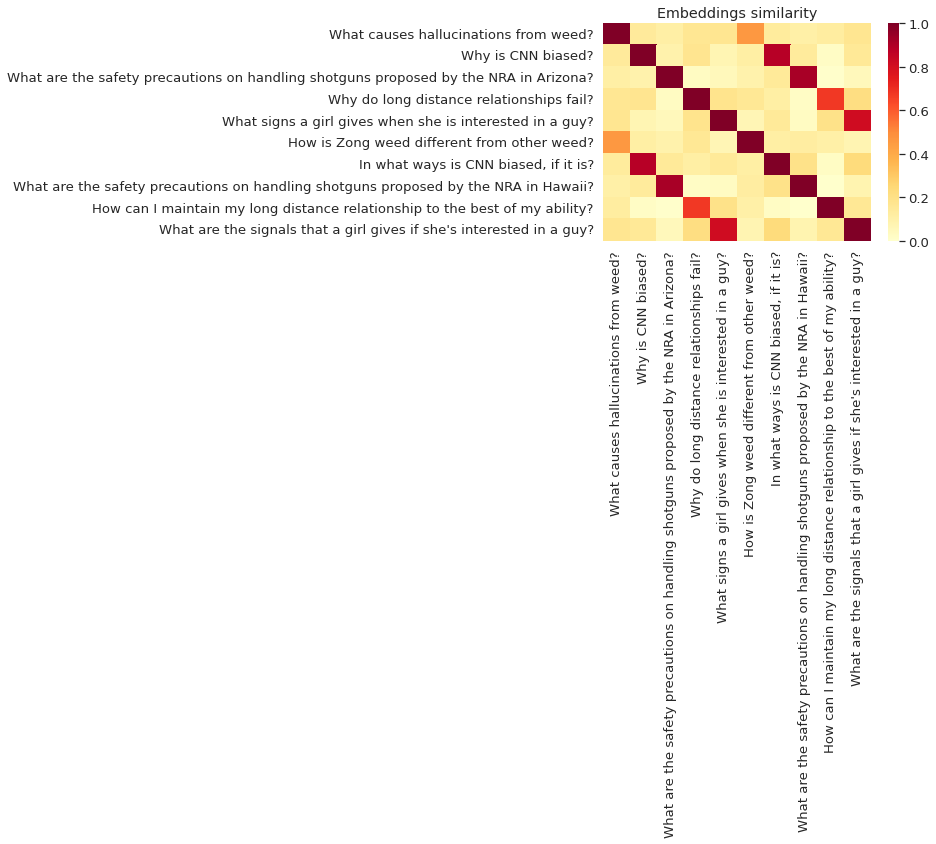

In [ ]:
message_embeddings = get_embeddings(top_5_questions)
plot_similarity(top_5_questions, message_embeddings, 90)

### Let's measure similarity and compare with labels on the first 100.000 question pairs

CS (cosine similarity) = 1 - CD (cosine distance)

In [ ]:
def measure_similarity(vector_1, vector_2):
  return 1 - cosine(vector_1, vector_2)

But before the measurement we'll shuffle the data

In [ ]:
data = data.sample(frac=1, random_state=SEED).iloc[:100_000]

In [ ]:
%%time

embeddings_question1 = get_embeddings(data['question1'])
embeddings_question2 = get_embeddings(data['question2'])

CPU times: user 32.6 s, sys: 899 ms, total: 33.5 s
Wall time: 30.9 s


In [ ]:
%%time
data['similarity'] = [measure_similarity(v_1, v_2) for v_1, v_2 in zip(embeddings_question1, embeddings_question2)]
data.head()

CPU times: user 1min 11s, sys: 5.53 s, total: 1min 17s
Wall time: 1min 6s


Unnamed: 0      id    qid1    qid2  \
210371       84854   84854  143398  143399   
208086      332448  332448  459439   30722   
265085       74260   74260  127292  127293   
173521      360105  360105  489838  489839   
59502        32573   32573   57911   24555   

                                                question1  \
210371  Are you allowed to choose your own battalion b...   
208086                        What's the purpose of life?   
265085  How long does a cop have to pull you over afte...   
173521               Can I develope mobile apps with c++?   
59502   Can people see that I have looked at their pic...   

                                                question2  is_duplicate  \
210371  Are you allowed to choose your own regiment an...             1   
208086                       What is the meaning of life?             0   
265085  If you videotape a cop when being pulled over ...             0   
173521            How can I develop mobile apps with C++?             1   
59502     How do l see who viewed my videos on Instagram?             0   

        similarity  
210371    0.897088  
208086    0.773056  
265085    0.573364  
173521    0.901956  
59502     0.662314

In [ ]:
data['bin_similarity'] = np.where(data['similarity'] > 0.9, 1, 0)
data[['is_duplicate', 'bin_similarity']].corr()

is_duplicate  bin_similarity
is_duplicate        1.000000        0.283596
bin_similarity      0.283596        1.000000

We can try to build precision-recall curve to determine the best threshold for distinguishing duplicate questions from the rest.

It seems like 0.89 is a good threshold for this dataset.

In [ ]:
plot_pr_curve(data['is_duplicate'], data['similarity'])

But simple search through Quora Question Pairs dataset is much less fascinating than search through dat from real question-answering resource, so it can be a good starting point to scrap new data from StackOverflow.com ✨

### StackOverflow data

datascience.stackexchange.com.7z was taken from https://archive.org/details/stackexchange

#### Posts

In [48]:
posts_df = pdx.read_xml('Posts.xml', ['posts', 'row'])
posts_df = posts_df.T
posts_df['post_type_id'] = posts_df[0].apply(lambda x: x.get('@PostTypeId'))
posts_df['title'] = posts_df[0].apply(lambda x: x.get('@Title'))
posts_df = posts_df[posts_df['post_type_id'] == '1']
posts_df[['post_type_id','title']].head()

post_type_id  \
0            1   
1            1   
4            1   
5            1   
6            1   

                                                                                                 title  
0                                   How can I do simple machine learning without hard-coding behavior?  
1  What open-source books (or other materials) provide a relatively thorough overview of data science?  
4                                                             Is Data Science the Same as Data Mining?  
5                       What are the advantages and disadvantages of SQL versus NoSQL in data science?  
6                                                      Use liblinear on big data for semantic analysis

#### Posts links

In [50]:
links_df = pdx.read_xml('PostLinks.xml', ['postlinks', 'row'])
links_df = links_df.T
links_df['link_type_id'] = links_df[0].apply(lambda x: x.get('@LinkTypeId'))
links_df['post_id'] = links_df[0].apply(lambda x: x.get('@PostId'))
links_df['id'] = links_df[0].apply(lambda x: x.get('@Id'))
links_df = links_df[links_df['link_type_id'] == '1']
links_df[['link_type_id','post_id', 'id']].head()

link_type_id post_id   id
0            1      75   50
1            1      59  172
2            1     361  387
3            1      61  392
4            1     370  451